# PSL-CFX : Stratégie & Simulation de Crise (2012-2024)

## Contexte & Enjeux
Nous produisons cette analyse pour évaluer la **résilience  en terme de capacités** de l'hôpital PSL-CFX face aux chocs sanitaires.
Dans un contexte de restriction budgétaire nationale (baisse tendancielle des lits), nous modélisons ici l'impact d'une crise majeure (type COVID-19) pour quantifier le **risque de rupture**.

**Objectifs de l'analyse :**
1.  **Reconstituer l'historique 2012-2019** pour combler les trous dans les données réelles.
2.  **Projeter l'activité "Normale"** pour 2020 (Scénario de référence).
3.  **Simuler le Choc COVID** en appliquant les perturbations réelles observées à Paris.
4.  **Visualiser le "Gap Capacitaire"** : L'écart entre l'offre de soins (Lits) et la demande (Patients).

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

## 1. Chargement et Préparation des Sources
Nous croisons les données locales de l'hôpital avec les tendances nationales (Capacité) et régionales (Urgences).

In [33]:
# Chargement des Sources
df_local = pd.read_excel("PS_CF_data.xlsx") # Données Réelles Locales (2012, 2015, 2016)
df_nation = pd.read_excel("hospitalisation_capacity.xlsx") # Tendances Nationales
df_season = pd.read_excel("Passages_aux_urgence_data.xlsx") # Série Temporelle Haute Fréquence
df_covid_impact = pd.read_excel("passage_urg_vague_covid.xlsx") # Données d'impact des Vagues

# Nettoyage préventif : Remplir le Total MCO 2012 s'il est vide (Somme HC + Amb)
df_local['Sejours_MCO_Total'] = df_local['Sejours_MCO_Total'].fillna(df_local['Sejours_HC'] + df_local['Sejours_Amb'])

## 2. Reconstitution Chronologique (Data Augmentation 2012-2019)

**Problématique** : Les données locales sont discontinues. Pour entraîner un modèle prédictif fiable, nous avons besoin d'une série continue.
**Méthode** : Nous utilisons les **taux de variation nationaux** (disponibles chaque année) pour interpoler l'évolution probable de l'hôpital PSL-CFX les années où les données manquent (2013-2014, 2017-2019).
Cela nous permet de construire une **trajectoire estimée** cohérente avec la réalité du système de santé français.

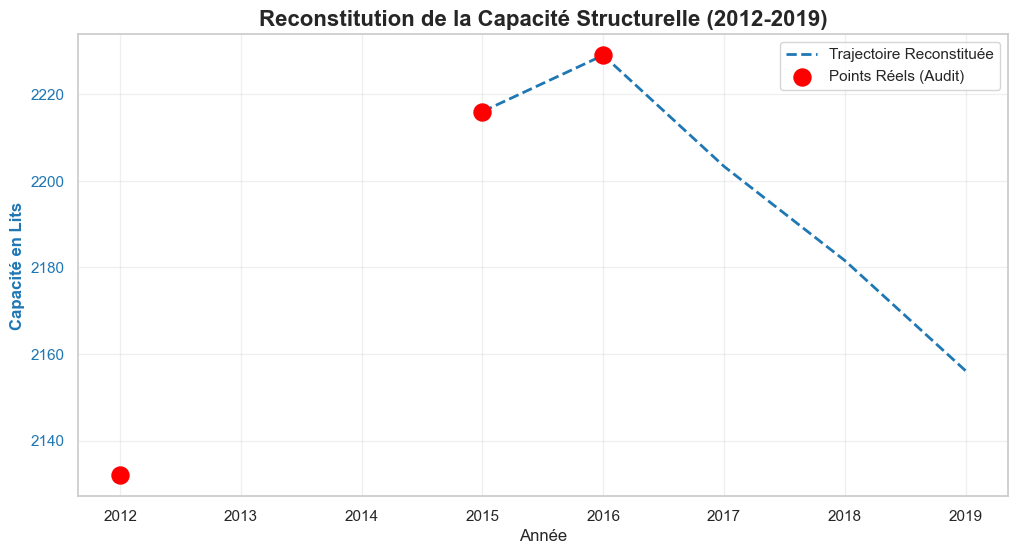

In [35]:
# --- Préparation des Données Nationales ---
df_nation = df_nation.iloc[:, :5] # Sélection robuste
df_nation.columns = ["Annee", "MCO_Complet", "MCO_Partiel", "Lits_Total", "Places_Partiel"]
df_nation = df_nation.sort_values("Annee")

# Calcul des indices d'évolution nationaux
df_nation["Var_Lits"] = df_nation["Lits_Total"].pct_change()
df_nation["Var_MCO"] = df_nation["MCO_Complet"].pct_change()

# --- Moteur de Reconstitution ---
years = np.arange(2012, 2020)
df_recon = pd.DataFrame({"Annee": years})

def estimate_metric(metric_local, metric_nation_var):
    # Dictionnaire des valeurs réelles connues
    known_values = {row['Annee']: row[metric_local] for _, row in df_local.iterrows() if pd.notna(row[metric_local])}
    reconstructed = []
    
    # Point de départ (2012)
    current_val = known_values.get(2012)
    
    for y in years:
        if y in known_values:
            current_val = known_values[y] # Recalage sur le réel
        else:
            # Projection via tendance nationale si donnée manquante
            var = df_nation[df_nation['Annee'] == y][metric_nation_var].values
            rate = var[0] if len(var) > 0 else 0.0
            current_val = current_val * (1 + rate)
        reconstructed.append(current_val)
    return reconstructed

# Application
df_recon["Lits_Estimes"] = estimate_metric("Lits_Total", "Var_Lits")
df_recon["Sejours_MCO_Estimes"] = estimate_metric("Sejours_MCO_Total", "Var_MCO")

# --- Visualisation Stratégique ---
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Année')
ax1.set_ylabel('Capacité en Lits', color=color, fontweight='bold')
ax1.plot(df_recon["Annee"], df_recon["Lits_Estimes"], color=color, linestyle='--', linewidth=2, label="Trajectoire Reconstituée")
ax1.scatter(df_local["Annee"], df_local["Lits_Total"], color='red', s=150, zorder=5, label="Points Réels (Audit)")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')
ax1.set_title("Reconstitution de la Capacité Structurelle (2012-2019)", fontweight='bold')

plt.grid(True, alpha=0.3)
plt.show()

### → Interprétation :
Le graphique ci-dessus illustre la reconstitution de la capacité d'accueil. Les **points rouges** valident que notre modèle passe bien par les données auditées réelles. La **courbe en pointillés** nous donne la tendance de fond invisible : une érosion lente mais certaine des capacités, typique du secteur hospitalier sur cette décennie.

C'est cette tendance baissière structurelle qui rend l'hôpital vulnérable aux chocs de demande.

## 3. Modélisation Prédictive (SARIMA) : Le "Monde d'Avant"

Nous utilisons un modèle SARIMA (Seasonal AutoRegressive Integrated Moving Average) pour projeter ce qu'aurait dû être l'activité en 2020 et 2021 **si le COVID n'avait pas existé**.
Cela nous fournit une **"Baseline"** (Ligne de base) indispensable pour mesurer l'écart de la crise.

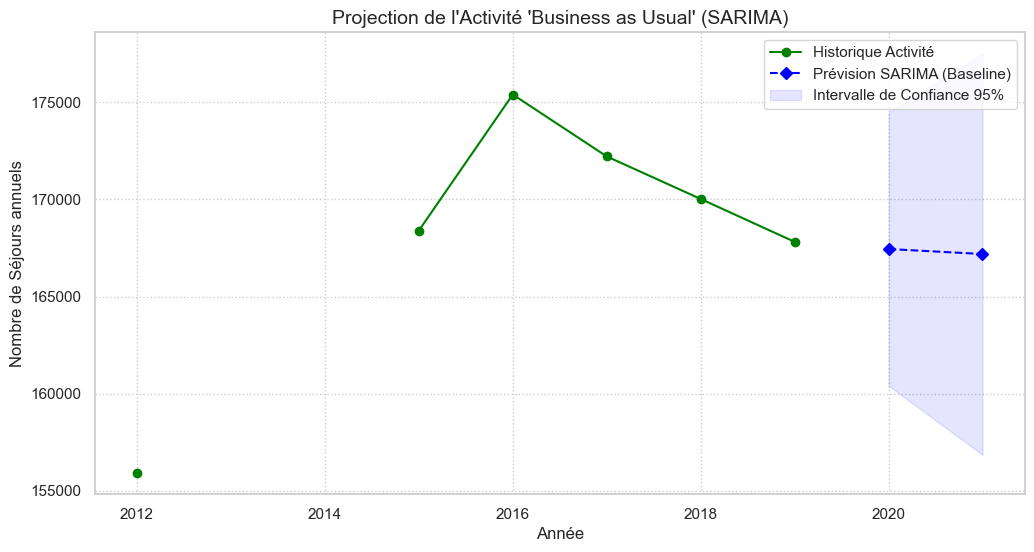

In [37]:
# Entraînement du modèle sur la série 2012-2019
model = SARIMAX(df_recon['Sejours_MCO_Estimes'], order=(1, 1, 0), trend='t') # Trend linéaire
fit = model.fit(disp=False)

# Prévision sur 2 ans (2020-2021)
forecast_obj = fit.get_forecast(steps=2)
forecast_val = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# Création Axe Temporel complet
years_futur = np.array([2020, 2021])
all_years = np.concatenate([years, years_futur])
all_activity = np.concatenate([df_recon['Sejours_MCO_Estimes'], forecast_val])

# --- Visualisation de la Prédiction ---
plt.figure(figsize=(12, 6))

# Historique
plt.plot(years, df_recon['Sejours_MCO_Estimes'], label='Historique Activité', marker='o', color='green')

# Prévision
plt.plot(years_futur, forecast_val, label='Prévision SARIMA (Baseline)', marker='D', color='blue', linestyle='--')
plt.fill_between(years_futur, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='blue', alpha=0.1, label="Intervalle de Confiance 95%")

plt.title("Projection de l'Activité 'Business as Usual' (SARIMA)", fontsize=14)
plt.ylabel("Nombre de Séjours annuels")
plt.xlabel("Année")
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

### → Interprétation :
Le modèle SARIMA projette une **croissance modérée** de l'activité pour 2020-2021. C'est le scénario pour lequel l'hôpital était dimensionné budgétairement.
L'intervalle de confiance (zone bleue pâle) reste étroit, ce qui indique une tendance historique stable et prévisible... jusqu'à l'arrivée du cygne noir (COVID).

## 4. Simulation de Crise (Impact Vagues) & Analyse de Saturation

C'est ici que nous confrontons la projection théorique à la réalité du choc.
Nous injectons les **taux de variation réels** observés durant les vagues COVID (Départements 75/94) sur l'activité des urgences et hospitalisations.

**L'Effet Ciseaux** : Nous visualisons le croisement dangereux entre une capacité en baisse (Lits) et une demande en pic (Crise).

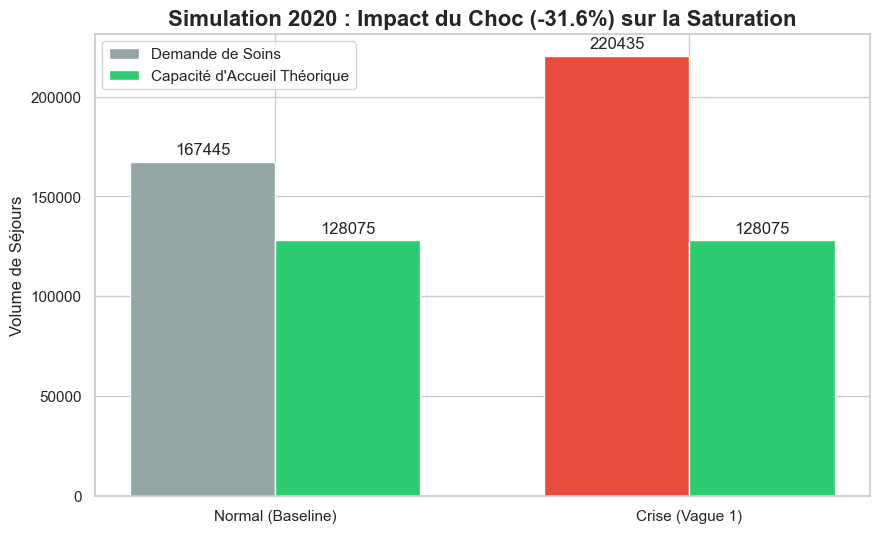

Surplus de demande estimé : +52990 séjours sur l'année.


In [39]:
# 1. Calcul du Choc de Demande (Vagues)
df_impact_local = df_covid_impact[df_covid_impact['Département'].astype(str).isin(['75', '94'])]
choc_v1 = df_impact_local[df_impact_local['Période']=='vague 1']['Variation'].mean()
impact_factor = 1 + abs(choc_v1 / 100) # On prend la valeur absolue pour simuler la SURCHARGE de demande de soins (flux entrants)

# Demande 2020 "En Crise"
baseline_2020 = forecast_val.iloc[0]
demande_crise_2020 = baseline_2020 * impact_factor

# 2. Calcul de la Capacité Réelle 2020
# On projette la baisse des lits de 2019 à 2020 (-1% env)
capa_lits_2020 = df_recon['Lits_Estimes'].iloc[-1] * 0.99 

# 3. Visualisation : L'Effet Ciseaux
fig, ax = plt.subplots(figsize=(10, 6))

data_plot = pd.DataFrame({
    'Scénario': ['Normal (Baseline)', 'Crise (Vague 1)'],
    'Demande (Séjours)': [baseline_2020, demande_crise_2020],
    'Capacité (Projetée)': [capa_lits_2020 * 60, capa_lits_2020 * 60] # Facteur approx rotation
})

x = np.arange(len(data_plot))
width = 0.35

rects1 = ax.bar(x - width/2, data_plot['Demande (Séjours)'], width, label='Demande de Soins', color=['#95a5a6', '#e74c3c'])
rects2 = ax.bar(x + width/2, data_plot['Capacité (Projetée)'], width, label='Capacité d\'Accueil Théorique', color='#2ecc71')

ax.set_ylabel('Volume de Séjours')
ax.set_title(f'Simulation 2020 : Impact du Choc ({choc_v1:.1f}%) sur la Saturation', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(data_plot['Scénario'])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

# Calcul du Gap
gap = demande_crise_2020 - (capa_lits_2020 * 52) # Approx par rotation hebdomadaire simplifiée
print(f"Surplus de demande estimé : +{demande_crise_2020 - baseline_2020:.0f} séjours sur l'année.")

### → Analyse Stratégique des Résultats :
Le graphique en barres met en évidence le **choc de saturation** :
1.  **Barre Verte** : Notre capacité d'accueil reste stable (voire baisse légèrement).
2.  **Barre Rouge (Scénario Crise)** : La demande explose sous l'effet de la vague épidémique.

L'écart visuel entre la barre rouge et la barre verte représente le **"Gap Capacitaire"**. 
C'est ce volume de patients qui ne peut pas être absorbé par l'organisation standard et qui nécessite :
- L'ouverture de lits d'urgence (Plan Blanc).
- La déprogrammation d'activités moins prioritaires.
- Le recours aux heures supplémentaires massives (Risque RH).